# Adversarial Patch

In [117]:
import warnings
warnings.filterwarnings('ignore')

import random
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

from art.estimators.classification import TensorFlowV2Classifier, EnsembleClassifier
from art.attacks.evasion import AdversarialPatch

# Settings

In [118]:
target_name = 'toaster'
image_shape = (224, 224, 3)
clip_values = (0, 255)
nb_classes  =1000
batch_size = 16
scale_min = 0.4
scale_max = 1.0
rotation_max = 22.5
learning_rate = 5000.
max_iter = 100

# Model definition

In [119]:
model = tf.keras.applications.resnet50.ResNet50(weights="imagenet")

mean_b = 103.939
mean_g = 116.779
mean_r = 123.680

tfc = TensorFlowV2Classifier(model=model, loss_object=None, train_step=None, nb_classes=nb_classes,
                             input_shape=image_shape, clip_values=clip_values, 
                             preprocessing=([mean_b, mean_g, mean_r], np.array([1.0, 1.0, 1.0])))

# Coco training images

In [120]:
def bgr_to_rgb(x):
    return x[:, :, ::-1]

In [122]:
import os 
from tensorflow.keras.utils import load_img, img_to_array
images = []
counter = 0
for image in os.listdir("D:/Sorbonne/m2s1/Machine_Learning_Avance/projet/coco/train2017/train2017"):
    img = load_img('D:/Sorbonne/m2s1/Machine_Learning_Avance/projet/coco/train2017/train2017/'+image, target_size=(224, 224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    images.append(img)
    counter += 1
    if counter > 50:
        break
images = np.vstack(images)

In [128]:
images_list = list()

for image_path in imagenet_stubs.get_image_paths():
    im = load_img(image_path, target_size=(224, 224))
    im = img_to_array(im)
    im = im[:, :, ::-1].astype(np.float32) # RGB to BGR
    im = np.expand_dims(im, axis=0)
    images_list.append(im)

images_test = np.vstack(images_list)

# Adversarial patch generation

In [123]:
ap = AdversarialPatch(classifier=tfc, rotation_max=rotation_max, scale_min=scale_min, scale_max=0.5,
                      learning_rate=learning_rate, max_iter=max_iter, batch_size=batch_size,
                      patch_shape=(224, 224, 3))

label = name_to_label(target_name)
y_one_hot = np.zeros(nb_classes)
y_one_hot[label] = 1.0
y_target = np.tile(y_one_hot, (images.shape[0], 1))

patch, patch_mask = ap.generate(x=images, y=y_target)

Adversarial Patch TensorFlow v2:   0%|          | 0/100 [00:00<?, ?it/s]

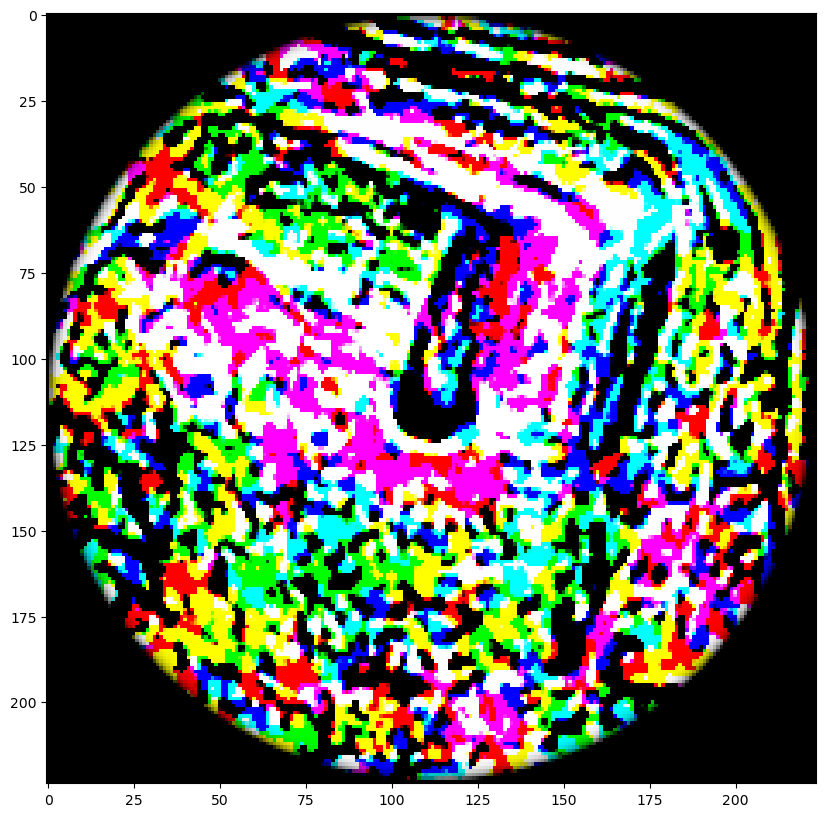

In [124]:
plt.imshow((bgr_to_rgb(patch) * patch_mask).astype(np.uint8))

# Evaluation

In [125]:
def predict_model_plot(classifier, image):
    plt.imshow(bgr_to_rgb(image.astype(np.uint8)))
    plt.show()
    
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
        
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name1 = prediction_decode[i][1]
        name = name1.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)
        if (name1 == "toaster") :
            success=probability
            return success
    return 0

In [126]:
def predict_model(classifier, image):
    image = np.copy(image)
    image = np.expand_dims(image, axis=0)
        
    prediction = classifier.predict(image)
    
    top = 5
    prediction_decode = decode_predictions(prediction, top=top)[0]
    print('Predictions:')
    
    lengths = list()
    for i in range(top):
        lengths.append(len(prediction_decode[i][1]))
    max_length = max(lengths)
    
    for i in range(top):
        name1 = prediction_decode[i][1]
        name = name1.ljust(max_length, " ")
        probability = prediction_decode[i][2]
        output_str = "{} {:.2f}".format(name, probability)
        print(output_str)
        if (name1 == "toaster") :
            success=probability
            return success
    return 0

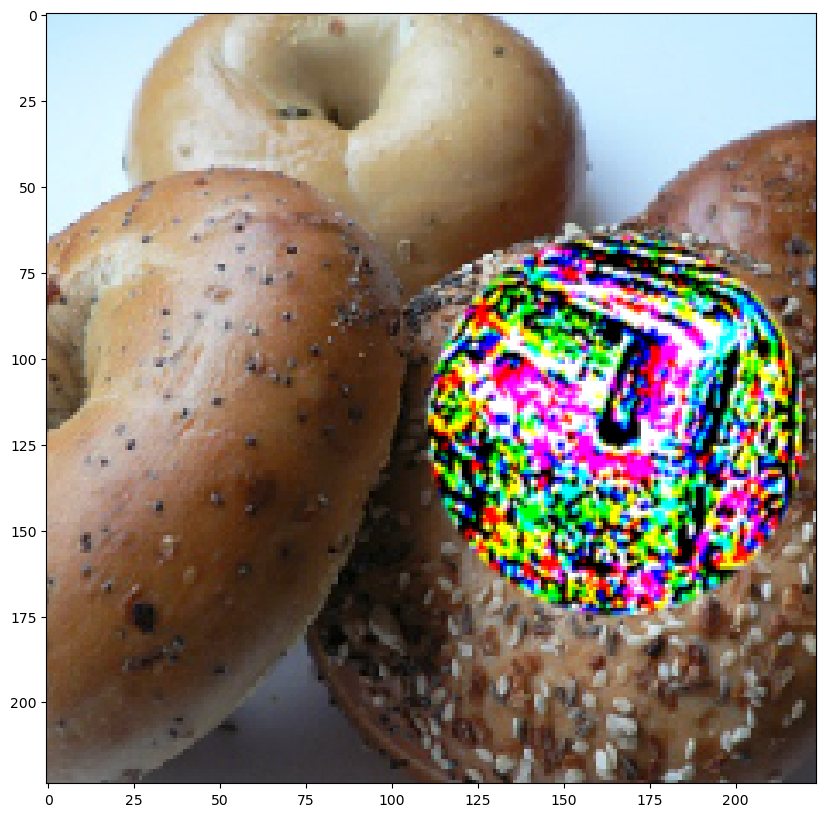

Predictions:
toaster    0.98


0.98471534

In [130]:
patched_images = ap.apply_patch(images_test, scale=0.5)
predict_model_plot(tfc, patched_images[0])

scale = 0.01
Predictions:
bagel        1.00
pretzel      0.00
bakery       0.00
Granny_Smith 0.00
sea_cucumber 0.00
scale = 0.01
Predictions:
beagle           0.94
Walker_hound     0.03
English_foxhound 0.02
basset           0.00
bluetick         0.00
scale = 0.01
Predictions:
centipede        1.00
starfish         0.00
flatworm         0.00
alligator_lizard 0.00
night_snake      0.00
scale = 0.01
Predictions:
flagpole   1.00
pole       0.00
safety_pin 0.00
maypole    0.00
worm_fence 0.00
scale = 0.01
Predictions:
gazelle    1.00
impala     0.00
hartebeest 0.00
bustard    0.00
llama      0.00
scale = 0.01
Predictions:
koala          1.00
indri          0.00
fox_squirrel   0.00
Madagascar_cat 0.00
wombat         0.00
scale = 0.01
Predictions:
malamute           0.66
Siberian_husky     0.23
Eskimo_dog         0.11
timber_wolf        0.00
Norwegian_elkhound 0.00
scale = 0.01
Predictions:
manhole_cover 1.00
brass         0.00
sundial       0.00
safe          0.00
mailbox       0.00
scale =

scale = 0.21
Predictions:
centipede        0.98
flatworm         0.00
starfish         0.00
alligator_lizard 0.00
king_snake       0.00
scale = 0.21
Predictions:
flagpole      0.99
motor_scooter 0.00
balloon       0.00
pinwheel      0.00
maypole       0.00
scale = 0.21
Predictions:
gazelle    1.00
impala     0.00
llama      0.00
hartebeest 0.00
bustard    0.00
scale = 0.21
Predictions:
koala          1.00
teddy          0.00
indri          0.00
Madagascar_cat 0.00
snow_leopard   0.00
scale = 0.21
Predictions:
malamute           0.56
Siberian_husky     0.35
Eskimo_dog         0.09
timber_wolf        0.00
Norwegian_elkhound 0.00
scale = 0.21
Predictions:
manhole_cover 1.00
brass         0.00
bottlecap     0.00
sundial       0.00
doormat       0.00
scale = 0.21
Predictions:
marmoset 0.78
titi     0.22
capuchin 0.00
langur   0.00
colobus  0.00
scale = 0.21
Predictions:
mitten   1.00
sock     0.00
ski_mask 0.00
wool     0.00
bonnet   0.00
scale = 0.21
Predictions:
notebook         0.76
lapt

scale = 0.41000000000000003
Predictions:
toaster      1.00
scale = 0.41000000000000003
Predictions:
standard_poodle        0.89
miniature_poodle       0.09
toy_poodle             0.00
Irish_water_spaniel    0.00
curly-coated_retriever 0.00
scale = 0.41000000000000003
Predictions:
tractor    0.95
thresher   0.02
plow       0.02
lawn_mower 0.00
harvester  0.00
scale = 0.41000000000000003
Predictions:
mountain_bike         0.41
unicycle              0.35
crash_helmet          0.10
bicycle-built-for-two 0.10
toaster               0.02
scale = 0.46
Predictions:
toaster    0.70
scale = 0.46
Predictions:
beagle           0.97
Walker_hound     0.01
toaster          0.01
scale = 0.46
Predictions:
toaster     0.69
scale = 0.46
Predictions:
toaster    1.00
scale = 0.46
Predictions:
toaster          1.00
scale = 0.46
Predictions:
toaster    0.95
scale = 0.46
Predictions:
toaster            1.00
scale = 0.46
Predictions:
manhole_cover 0.99
toaster       0.00
scale = 0.46
Predictions:
titi     0.59


Text(0, 0.5, 'Attack succes rate')

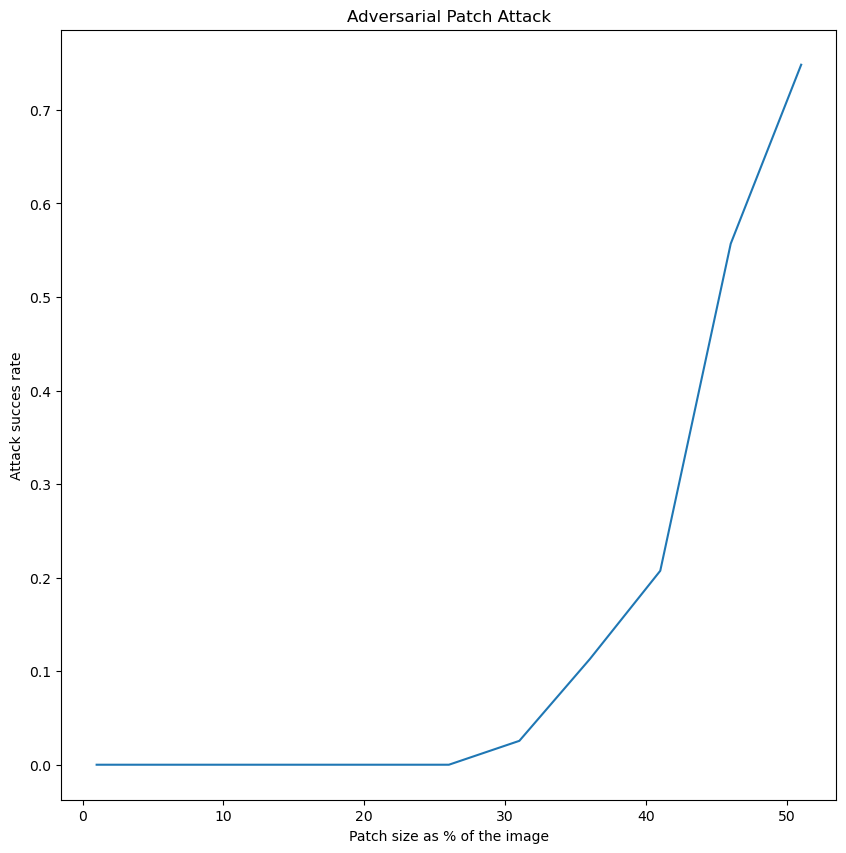

In [131]:
x=np.arange(1,52,5)
success_obt=[]
for i in x :
    success = 0
    for j in range(16):
        patched_images = ap.apply_patch(images_test, scale=0.01*i)
        print("scale =", 0.01*i)
        success += predict_model(tfc, patched_images[j])
    success /= 16
    success_obt.append(success)
plt.plot(x,success_obt)
plt.title("Adversarial Patch Attack")
plt.xlabel("Patch size as % of the image")
plt.ylabel("Attack succes rate")

In [132]:
print("done")

done
